## Cicuit Depth Issues with Controlled Mixer Hamiltonians
***

 In order to transition between feasible spaces, controlled mixer hamiltonians are employed. These hamiltonians use multi-qubit control gates such as toffoli gate. In qiskit, the toffoli gate only uses 2 control bits with an option for ancilla qubit. However, if the user requires >2 control qubits, then they can use the multi-contorl toffoli gate(mct). This notebook will invtestigate how the mct behaves as the number of controlled bits increases.

In [1]:
from qiskit import *
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

### Investigate the circuit depth for a mct as degree of a vertex increases:
***



In [2]:
V=[0]
E=[]

depth = []
density = []

for i in range(1,11):
    n     = i
    V.append(n)
    E.append((0,n,1.0))
    

    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    
    density.append(nx.density(G))
    
    qc = QuantumCircuit()
    qr = QuantumRegister(len(G.nodes)+ 1, 'qubit')
    qc.add_register( qr )
    
    ancilla_qubit = qr[len(qr)-1]
    theta = 2.222222
    
    bfs = dict(nx.traversal.bfs_successors(G,0,depth_limit=1))
    print(bfs)
    control_bits = list(qr[nodes] for nodes in bfs[0])
    qc.mct(control_bits,ancilla_qubit,None,mode="noancilla")
#     qc.draw(output='mpl')
    depth.append(qc.depth())

{0: [1]}
{0: [1, 2]}
{0: [1, 2, 3]}
{0: [1, 2, 3, 4]}
{0: [1, 2, 3, 4, 5]}
{0: [1, 2, 3, 4, 5, 6]}
{0: [1, 2, 3, 4, 5, 6, 7]}
{0: [1, 2, 3, 4, 5, 6, 7, 8]}
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9]}
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


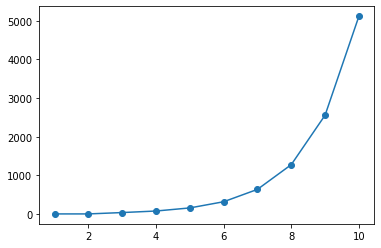

In [3]:
%matplotlib inline
_ = plt.plot(range(1,11), depth, 'o-')

In [4]:
print(depth)

[1, 1, 36, 76, 156, 316, 636, 1276, 2556, 5116]


From the graph above, the increase of the circuit depth increases exponentially as the number of controlled qubits increases from 1 to approximately 5000. This would greatly reduce the coherence of the entire circuit hence we highly advise users to avoid using the circuit with the mct gate.

### Using X rotation Hamiltonians only:

***

In [5]:
V=[0]
E=[]

depth = []

for i in range(1,11):
    n     = i
    V.append(n)
    E.append((0,n,1.0))
    

    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)

    qc = QuantumCircuit()
    qr = QuantumRegister(len(G.nodes), 'qubit')
    qc.add_register( qr )
    
    theta = 2.222222
    
    for n in range(len(G.nodes)):
        qc.rx(theta, n)
        
    depth.append(qc.depth())

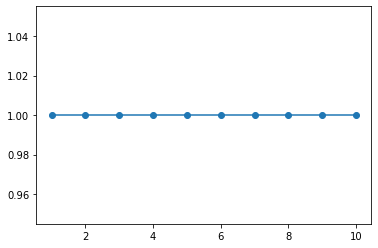

In [6]:
%matplotlib inline
_ = plt.plot(range(1,11), depth, 'o-')

The circuit depth remains as 1 throughout when X rotation gates are used, this because all of these gates can be applied in parallel, thus keeping the circuit depth as 1 for all values of n, the number of qubits. This implies that it is better for the circuit to transition between all possible subspaces instead of transitioning between feasible subspaces determined by the controlled hamiltonians.

### Sparse VS Dense Graphs for Controlled Mixer Hamiltonians: 
***

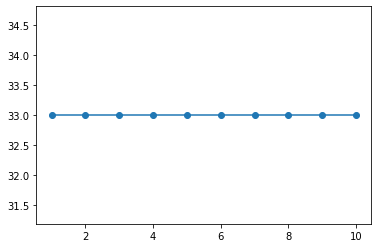

In [7]:
import scipy.sparse

depth = []

#Max Degree = 2
for i in range(1,11):
    A = scipy.sparse.eye(11,11,i)
    G = nx.from_scipy_sparse_matrix(A)

    qc = QuantumCircuit()
    qr = QuantumRegister(len(G.nodes) + 1, 'qubit')
    qc.add_register( qr )
    
    ancilla_qubit = qr[len(qr)-1]
    theta = 2.222222
    
    for n in G.nodes:
            bfs = dict(nx.traversal.bfs_successors(G,n,depth_limit=1))
            for source in bfs:
                control_bits = list(qr[int(i)] for i in bfs[source])
                qc.mct(control_bits,ancilla_qubit,None,mode="noancilla")
                qc.mcrx(theta, [ancilla_qubit], qr[int(source)])
                qc.mct(control_bits,ancilla_qubit,None,mode='noancilla')
                qc.barrier()
        
    depth.append(qc.depth())
    
    
%matplotlib inline
_ = plt.plot(range(1,11), depth, 'o-')

### Dense Graphs:

In [8]:
E = []
V = [0]
depth = []

for i in range(1,11):
    n     = i
    V.append(n)

    for e in range(i):
        E.append((i,e,1.0))
    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    
    qc = QuantumCircuit()
    qr = QuantumRegister(len(G.nodes) + 1, 'qubit')
    qc.add_register( qr )
    
    ancilla_qubit = qr[len(qr)-1]
    theta = 2.222222
    
    for n in G.nodes:
            bfs = dict(nx.traversal.bfs_successors(G,n,depth_limit=1))
            for source in bfs:
                control_bits = list(qr[int(i)] for i in bfs[source])
                qc.mct(control_bits,ancilla_qubit,None,mode="noancilla")
                qc.mcrx(theta, [ancilla_qubit], qr[int(source)])
                qc.mct(control_bits,ancilla_qubit,None,mode='noancilla')
                qc.barrier()
        
    depth.append(qc.depth())
    

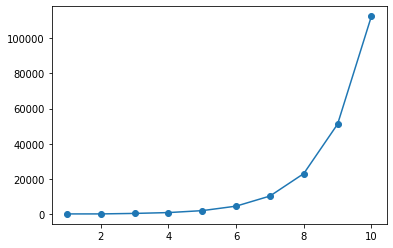

In [9]:
%matplotlib inline
_ = plt.plot(range(1,11), depth, 'o-')

 Sparse graph tends to keep the circuit depth lower as compared to dense graphs, this is due to the fact that the sparse graph have disjoint sets and each vertex has a degree lower or equal to 2. Hence able to keep the depth of the circuit constant as the mixer gates can be more 'parallel' as compared to the dense graph.
<br>
There is a need to find better alternatives that can be used as a toffoli gate but with a lower gate count as comapred to qiskit's native mct gate

In [10]:
print(depth)

[6, 9, 292, 765, 1878, 4431, 10184, 22977, 51130, 112563]


QAOAToolkit offers users with a pre-defined function called *controlledXMixer()* that implements $H_f =  \Lambda_{f(y)} (e^ {−iβX})$ so that the mixer hamiltonians limits the hilbert space within all feasible states since not all states are possible in certain problems. This methods also tries to reduce the circuit depth, however, at higher  values the numbers are still high as such users are advised to take note of the maximum degree of the graph that they are using:

In [11]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import mixer_hamiltonian as mix_ham

mixer_ham = mix_ham()

In [12]:
E = []
V = [0]
depth = []

for i in range(1,11):
    n     = i
    V.append(n)

    for e in range(i):
        E.append((i,e,1.0))
    G = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    
    
    ancilla_qubit = qr[len(qr)-1]
    theta = 2.222222
    
    mixer_ham.controlledXMixer([theta], 1, G, False)
    qc = mixer_ham.get_quantumCircuit()
        
    depth.append(qc.depth())

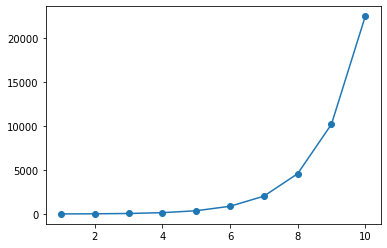

In [13]:
%matplotlib inline
_ = plt.plot(range(1,11), depth, 'o-')

In [14]:
print(depth)

[2, 15, 51, 143, 363, 871, 2019, 4575, 10203, 22487]
